<a href="https://colab.research.google.com/github/MilanCugur/Neuroevolution-LocalSearch/blob/master/Baseline_Model/Baseline_Neuroevolution_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Loading

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [10]:
import numpy as np
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPool2D, Add, Activation, Flatten, Concatenate, Dense, Dropout, BatchNormalization
from keras.optimizers import Adam  
from keras.losses import categorical_crossentropy
from keras.layers import LeakyReLU, concatenate
from keras.layers.advanced_activations import ReLU
from keras.initializers import glorot_normal
import keras.backend as K
from keras.models import load_model  # Save model params

def extract_dataset(path):
  """
  extract DoubledMNIST dataset
  Argument: path to .zip file with the dataset
  Return value: x_train, y_train, x_test, y_test lists of numpy arrays 
  
  (DoubledMNIST dataset: train size 120k images 56x56, test size 20k images 56x56)
  """
  # import libraries
  import os                     # for basic os operations
  from zipfile import ZipFile 
  from skimage import io
  import shutil
  
  if not path.endswith('.zip'):
    raise ValueError("Error: path is not '.zip' file")
  
  archive = ZipFile(path, 'r')  # extract
  archive.extractall('./DoubledMNIST')
  archive.close()
  del archive
  
  x_train = []
  y_train = []
  x_test = []
  y_test = []
  
  for file in os.listdir('./DoubledMNIST/train'):
    img = io.imread(os.path.join('./DoubledMNIST/train', file))
    x_train.append(np.array(img))
    y_train.append(int(file.split('_')[1]))
  
  for file in os.listdir('./DoubledMNIST/test'):
    img = io.imread(os.path.join('./DoubledMNIST/test', file))
    x_test.append(np.array(img))
    y_test.append(int(file.split('_')[1]))
    
  shutil.rmtree('./DoubledMNIST')
  return np.array(x_train), np.array(y_train), np.array(x_test), np.array(y_test)

Using TensorFlow backend.


In [0]:
def load_mnist(doubled=0, ntrain=None, ntest=None):
    """
    doubled==0 -> load MNIST; doubled==1-> load DoubledMNIST
    ntrain - number of train samples
    ntest - number of test samples
    """

    from keras.utils import to_categorical
    import numpy as np

    if doubled==0:
        # load mnist
        from keras.datasets import mnist

        (_x_train, _y_train), (_x_test, _y_test) = mnist.load_data()
        if ntrain==None:
            ntrain = _x_train.shape[0]
        if ntest==None:
            ntest = _x_test.shape[0]
        assert ntrain<=_x_train.shape[0] and ntest<=_x_test.shape[0]
    else:
        # load doubled mnist
        _x_train, _y_train, _x_test, _y_test = extract_dataset('./drive/My Drive/ni_sem/DoubledMNIST.zip')

    # Prepare images
    box_size = _x_train.shape[1]
    y_train = to_categorical(_y_train)[:ntrain]
    y_test = to_categorical(_y_test)[:ntest]
    x_train = np.array(_x_train).astype('float32')[:ntrain]
    x_train /= 255
    x_train = np.reshape(x_train,[-1, box_size, box_size, 1])
    x_test = np.array(_x_test).astype('float32')[:ntest]
    x_test /= 255
    x_test = np.reshape(x_test, [-1, box_size, box_size, 1])
    return x_train, y_train, x_test, y_test, box_size

In [12]:
%%time
x_train, y_train, x_test, y_test, box_size = load_mnist(doubled=0, ntrain=10000, ntest=1000)

11493376/11490434 [==============================] - 1s 0us/step
CPU times: user 383 ms, sys: 120 ms, total: 503 ms
Wall time: 6.76 s


In [13]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((10000, 28, 28, 1), (10000, 10), (1000, 28, 28, 1), (1000, 10))

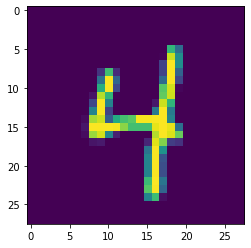

[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]


In [14]:
from matplotlib import pyplot as plt  # smal demonstration

plt.imshow(x_test[19].reshape((x_test.shape[1], x_test.shape[2])))
plt.show()

print(y_test[19])

# CNN tools

In [0]:
STAGES = np.array(["s1","s2","s3"]) # S
NUM_NODES = np.array([3,4,5])       # K
FILTERS = np.array([32, 48, 64])
sampleIndividual = [1, 0, 1,   1, 1, 0, 1, 0, 0,  1, 0, 1, 0, 0, 1, 0, 0, 0, 1]

# sampleIndividual = [1, 0, 1,   1, 0, 1, 0, 0, 1,  1, 0, 1, 0, 0, 1, 0, 0, 0, 1]; radi klasicna CNN
# stage1 examples
# sampleIndividual = [1, 0, 0,   1, 0, 1, 0, 0, 1,  1, 0, 1, 0, 0, 1, 0, 0, 0, 1]; radi; trojka eliminisana
# sampleIndividual = [0, 1, 0,   1, 0, 1, 0, 0, 1,  1, 0, 1, 0, 0, 1, 0, 0, 0, 1]; radi; dvojka eliminisana
# sampleIndividual = [0, 0, 1,   1, 0, 1, 0, 0, 1,  1, 0, 1, 0, 0, 1, 0, 0, 0, 1]; radi; jedinica eliminisana
# sampleIndividual = [0, 0, 0,   1, 0, 1, 0, 0, 1,  1, 0, 1, 0, 0, 1, 0, 0, 0, 1]; radi; samo jedna konv.
# stage2 examples
# sampleIndividual = [1, 0, 1,   0, 0, 0, 0, 0, 1,  1, 0, 1, 0, 0, 1, 0, 0, 0, 1]; radi 0->3->4->5
# sampleIndividual = [1, 0, 1,   0, 1, 0, 0, 0, 0,  1, 0, 1, 0, 0, 1, 0, 0, 0, 1]; radi 0->1->3->5
# sampleIndividual = [1, 0, 1,   1, 1, 0, 1, 0, 0,  1, 0, 1, 0, 0, 1, 0, 0, 0, 1]; radi; 0->1->2,3,4->5

In [0]:
def __create_indices(num_nodes):
  """
  num_nodes - number of nodes per each stage

  Calculate bits indices (startindex, length) for each stage 
  """
  l =  0                              # genome length
  bits_indices, i = np.empty((0,2),dtype = np.int32), 0 
  for Ks in num_nodes:
    length = Ks * (Ks - 1)
    bits_indices = np.vstack([bits_indices,[i, i + int(0.5 * length)]])
    i += int(0.5 * length)
    l += length
  l = int(0.5 * l)
  return bits_indices, l

def CNN_build(stages, num_nodes, n_filters, individual, box_size, n_classes, verbose=0):
  """
  stages - array of stage names
  num_nodes - number of conv nodes per each stage
  n_filters - number of filters per stage
  individual - binary list representing individual architecture
  box_size - expect input images like (box_size, box_size)
  n_classes - number of output clasees

  Build CNN architecture from the given list
  """

  L = len(individual)
  bits_indices, _L= __create_indices(num_nodes)
  assert(L==_L)  # small check of the input individual connections info

  if(verbose):
    print('Starting network building..')
  image_shape = (box_size, box_size, 1) 
  x_input = Input(shape=image_shape)  
  previous = None # output from previous stage (initially input of CNN)
  # Build stage by stage
  for i, (s, Ks, n_filter) in enumerate(zip(stages, num_nodes, n_filters)):
    if i==0:
      previous = x_input
    if(verbose):
        print('\nBuild layer', s, ':', Ks, 'nodes,', n_filter, 'filters.')
    stage_indices = individual[bits_indices[i][0]:bits_indices[i][1]]                  # connection indices for current stage nodes; ex. [1, 0, 1, 0, 0, 1, 0, 0, 0, 1]
    stage_indexes = np.split(range(int(Ks*(Ks-1)/2)),np.cumsum(range(Ks - 1)))[1:]     # connection indexes for current stage nodes; ex. [array([0]), array([1, 2]), array([3, 4, 5]), array([6, 7, 8, 9])]
    stage_nodes = []                                                                   # nodes in a stage; ex. [vs1_1, vs1_2, vs1_3] (0, 4 are dummy)
    to_him = list(np.zeros(Ks))                                                              # number of nodes to which i-th node points to
    from_him = list(np.zeros(Ks))  
    if(verbose):                                                          # number of nodes from i-th node to others
        print('Stage indices:', stage_indices)
        print('Stage indexes:', stage_indexes)

    # default stage input node
    if(verbose):
        print('Building '+'v'+str(s)+'_0')
    vs0 = Conv2D(filters=n_filter, kernel_size=(3,3), strides=(1,1), activation='relu', padding='same', name='v'+str(s)+'_0')(previous)  # TODO
    if(verbose):
        print('Builded '+'v'+str(s)+'_0')

    # first node and trivial vs0->vs1
    if(verbose):
        print('Building '+'v'+str(s)+'_1')
    vs1 = Conv2D(filters=n_filter, kernel_size=(3,3), strides=(1,1), activation='relu', padding='same', name='v'+str(s)+'_1')(vs0) 
    stage_nodes += [vs1]
    if(verbose):
        print('Builded '+'v'+str(s)+'_1')

    for j in range(2, Ks+1):
      name = 'v'+str(s)+'_'+str(j)  # name of the current node
      if(verbose):
        print('Building '+name)
      tonode = stage_indices[stage_indexes[j-2][0]:stage_indexes[j-2][-1]+1]  # slice from stage_indices
      input = None  # Input to current node
      if sum(tonode)==0:  # empty input, connect to vs0
        input = vs0
      else:  # have some input
        for k, connection in enumerate(tonode):
          if connection==1:
            from_him[k] += 1
            to_him[j-1] += 1
            if input is None:
              input = stage_nodes[k]
            else:
              input = Add()([input, stage_nodes[k]])
      v = Conv2D(filters=n_filter, kernel_size=(3,3), strides=(1,1), activation='relu', padding='same', name='v'+str(s)+'_'+str(j))(input) 
      stage_nodes += [v]
      if(verbose):
        print('Builded node '+name)

    if(verbose):
        print('from_him: ', from_him)
        print('to_him: ', to_him)
        print('stage_nodes: ', stage_nodes)

    if sum(from_him)==sum(to_him)==0:  # only one convolution vs0
        previous = MaxPool2D(pool_size=(2,2), padding='same')(vs0)
    else:  # have some of the ordinary nodes
        if(verbose):
            print('Building '+'v'+str(s)+'_'+str(Ks+1))
        input = None  # last node no output definitelly
        for k in range(len(stage_nodes)):
            if from_him[k]==0 and to_him[k]!=0:  # no connections from that node
                if(verbose):
                    print('Connect to last node node', k, ' ', stage_nodes[k])
                if input is None:
                    input = stage_nodes[k]
                else:
                    input = Add()([input, stage_nodes[k]])
        vsKs = Conv2D(filters=n_filter, kernel_size=(3,3), strides=(1,1), activation='relu', padding='same', name='v'+str(s)+'_'+str(Ks+1))(input) # defaul stage output node
        if(verbose):
            print('Builded '+'v'+str(s)+str(Ks+1))
        previous = MaxPool2D(pool_size=(2,2), padding='same')(vsKs)
  
  # Adding FC part of NN
  x = Flatten(name='flatten')(previous)                                                                                       
  x = Dense(units=32, activation='relu', name='next_to_last')(x)         
  x = Dense(units=n_classes, activation='softmax', name='last')(x)

  # Creaate Model
  model = Model(inputs=x_input, outputs=x, name='individual')
  if(verbose):
    print('Created Network builded.')
  return model

In [17]:
model = CNN_build(STAGES, NUM_NODES, FILTERS, sampleIndividual, box_size, 10, 0)

In [0]:
def compile_model(model):
  """
  model - created Keras model

  Compile forwarded model, and return it compiled
  """

  model.compile(optimizer=Adam(lr=1e-3), loss=categorical_crossentropy, metrics=['accuracy'])
  return model

In [19]:
model = compile_model(model)

In [0]:
def visualize_model(model):
  """
  model - created Keras model

  plot forwarded model architecture
  """
  from keras.utils import plot_model

  print('Model summary: ')
  model.summary()
  plot_model(model, to_file='model.png')
  return

In [21]:
visualize_model(model)

Model summary: 
Model: "individual"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
vs1_0 (Conv2D)                  (None, 28, 28, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
vs1_1 (Conv2D)                  (None, 28, 28, 32)   9248        vs1_0[0][0]                      
__________________________________________________________________________________________________
vs1_2 (Conv2D)                  (None, 28, 28, 32)   9248        vs1_1[0][0]                      
_________________________________________________________________________

In [0]:
def train_model(model, x_train, y_train, x_test, y_test, epochs, batch_size, verbose=1, validation_split=0.0, callbacks=[]):
    """
    model - compiled CNN model
    x_train - input images
    y_train - input labels (one hot encoded)
    x_test - test images
    y_test - test labels (one hot encoded)
    epochs - number of epochs
    batch_size - mini batch size of training
    verbose - verbose of training
    validation_split - data split used for validation

    Train forwrded model. Returns (train history, model obtained test accuracy)
    """
    if (epochs == 0):
        # for faster testing
        # print('only eval, without training')
        return None, model.evaluate(x_test, y_test)
    # print('training and eval')
    history = model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, verbose=verbose, validation_split=validation_split, callbacks=callbacks)
    return history, model.evaluate(x_test, y_test)

In [0]:
history, result = train_model(model, x_train, y_train, x_test, y_test, 1, 1024, 1)
result

In [0]:
result

In [0]:
history

In [0]:
def toPseudo(model):
    """
    model - input CNN model
    return - structure that describe model weights for later from that model loading
    """
    return [(layer.get_config()['name'], layer.get_weights()) for layer in model.layers]

In [0]:
def loadWeights(toModel, fromPseudoModel, numSameStages, numNodesPerStage):
    '''
    toModel: keras model for which to load weights
    fromPseudoModel: list of (layer name, layer weights) from which to load weights
    numSameStages: number of first same stages; can be 0, 1, 2, 3; trivial cases 0 and 3
    numNodesPerStage: number of nodes per stage; ex. [3,4,5]

    You need to call model.compile. This can be done either before or after the model.load_weights 
    call but must be after the model architecture is specified and before the model.predict call.
    returns the model with loaded weights from file

    IMPORTANT: toModel and fromModel MUST HAVE exactly the same architecture on first numSameStages! (same indices eqvivalently)
    TODO: add critical pool if want more pooling operations in architecture
    '''
    assert numSameStages<=len(numNodesPerStage)
    allflag = (numSameStages==len(numNodesPerStage))  # to load all weights
    for i, (name, weights) in enumerate(fromPseudoModel):
        #print(name, weights) 

        if numSameStages==0:
            if not allflag:
                break

        toModel.layers[i].set_weights(weights)

        if 'max_pooling' in name:
            numSameStages-=1         

# Genetic Algorithm

In [0]:
import numpy as np
from random import random, seed

In [90]:
np.random.seed(42) # reproducible
class Genetic:
    def __init__(self, pc, qc, pm, qm, numGen, numInd, geneLength, bitIndices):
        ''' 
        pc: probability of crossover - whether crossover process begins
        qc: probability of stages being exchanged - while in crossover process
        pm: probability of mutation - whether mutation process begins
        qm: probability of a per bit mutation - while in mutation process
        numGen: number of generations
        numInd: number of individuals
        bitIndices: 2d matrix where each row has two columns - first is the index, and second is the length of bits in gene that code each segment
        '''
        self.pc = pc
        self.qc = qc
        self.pm = pm
        self.qm = qm
        self.numGen = numGen
        self.currNumGen = 0
        self.numInd = numInd
        self.geneLength = geneLength
        self.bitIndices = bitIndices
        self.oldGen = None
        self.initFirstGeneration()
    
    def initFirstGeneration(self):
        ''' 
        initializes the first generation
        '''
        self.currNumGen = 1
        self.currGen = np.random.randint(0, 2, (self.numInd, self.geneLength))

    def getCurrentGeneration(self):
        return self.currGen

    def selection(self, fitness):
        '''
        returns indices of individuals that survived the selection
        '''
        npfit = np.array(fitness)
        proba = npfit - np.min(npfit) # removes the worst one
        proba = proba / np.sum(proba)

        return np.random.choice(self.numInd, replace=True, size=self.numInd, p=proba)

    def mutate(self, newGen, indices):
        '''
        mutates individuals in newGen on positions where indices are 0 (because those individuals didn't mate)
        '''
        for i, had in enumerate(indices):
            if had == 0 and np.random.random() <= self.pm:
                newGen[i] = self.mutateIndividual(self.currGen[i])
            else:
                newGen[i] = np.copy(self.currGen[i])

    def mutateIndividual(self, individual):
        '''
        returns a new individual by mutating the given one
        '''
        mut = np.copy(individual)
        for i, val in enumerate(mut):
            if np.random.random() <= self.qm:
                mut[i] = 1 - mut[i]

        return mut

    def crossover(self, individualA, individualB):
        '''
        returns two new individuals by performing crossover on two given individuals.
        it takes care to only swap the whole segments, and not bits within segments
        '''
        a = np.copy(individualA)
        b = np.copy(individualB)

        for segment in self.bitIndices:
            if np.random.random() <= self.qc:
                start = segment[0]
                end = segment[1]
                tmpa = np.copy(a[start:end])
                a[start:end] = b[start:end]
                b[start:end] = tmpa

        return a, b

    def newGeneration(self, fitness, verbose=False):
        '''
        creates a new generation of individuals by selection, crossover, and mutation 
        of previous generation. Selection is based on the rulet method

        fitness - np array of fitness metrics for all individuals, based on which to construct rulet
        '''
        self.currNumGen += 1
        if self.currNumGen > self.numGen:
            raise Exception(f"currNumGen > numGen, {self.currNumGen} > {self.numGen}")
        newGenIdx = self.selection(fitness)
        if verbose:
            print(f'survived selection: {newGenIdx}')
        newGen = np.zeros((self.numInd, self.geneLength), dtype='int32') # np matrix of new generation
        hadCrossoverIdx = np.zeros(self.numInd) # tracks if an individial had a crossover
        assert(len(newGen)%2 == 0)
        # for each pair of neighbours, try crossover
        for i in range(0, len(newGen), 2):
            if np.random.random() <= self.pc:
                newGen[i], newGen[i+1] = self.crossover(self.currGen[newGenIdx[i]], self.currGen[newGenIdx[i+1]])
                hadCrossoverIdx[i] = 1
                hadCrossoverIdx[i+1] = 1

        self.mutate(newGen, hadCrossoverIdx)
        
        self.oldGen = self.currGen
        self.currGen = newGen

    def findIndividualsWithSameRoots(self, verbose=False):
        '''
        for each individual in a new generation finds the indices of individuals in the old generation 
        which had the same firts n segments

        returns a list, where i-th element has a touple (listOfParentsWithSameSegment, numberOfSameSegments)
        '''
        parentsAndNumSegments = []
        for indiv in self.currGen:
            parents, numSameSegments = self.hasSameRoots(indiv)
            parentsAndNumSegments.append((parents, numSameSegments))
            if numSameSegments > 0 and verbose:
                print('individual:',indiv)
                print(f'has the same {numSameSegments} first segments as:')
                print(parents)
                print(f'e.g: {self.oldGen[parents[0]]}')

        return parentsAndNumSegments


    def hasSameRoots(self, individual):
        '''
        returns indices of individuals from last generations which have the biggest same root as the
        given individual, and returns the number of segments which are the same (starting from the first)
        '''
        for i, segment in reversed(list(enumerate(self.bitIndices))):
            nColumns = segment[1]
            # print('bools',(self.oldGen[:,:nColumns] == individual[:nColumns]))
            # print('oldgen:',self.oldGen)
            # print('ind:', individual)
            # find rows which have the individual (only look at the part of the colums)
            matchedRows = (self.oldGen[:,:nColumns] == individual[:nColumns]).all(axis=1)
            sameRootIndividuals = np.where(matchedRows)[0]
            if sameRootIndividuals.size > 0:
                return sameRootIndividuals, i+1

        return np.empty(0), 0

geneLength = L
gen = Genetic(0.2, 0.3, 0.8, 0.1, 10, 10, geneLength, BITS_INDICES)
print('mean1', np.mean(gen.getCurrentGeneration()))
gen.newGeneration(np.random.random(10))
print('mean2', np.mean(gen.getCurrentGeneration()))

mean1 0.5105263157894737
mean2 0.5157894736842106


In [0]:
import types
STAGES = np.array(["s1","s2","s3"]) # S
NUM_NODES = np.array([3,4,5])       # K

BIT_INDICES, L = __create_indices(NUM_NODES)
# params is used as function parameter throught the core algorithm
params = types.SimpleNamespace()
params.pc = 0.2 # pc: probability of crossover - whether crossover process begins
params.pm = 0.8 # pm: probability of mutation - whether mutation process begins
params.qc = 0.3 # qc: probability of stages being exchanged - while in crossover process
params.qm = 0.1 # qm: probability of a per bit mutation - while in mutation process
params.geneLength = L # number of bits needed to encode the gene
params.numGenerations = 20 # 10 # number of generations
params.numIndividuals = 20 # 10 # number of individuals
params.bitIndices = BITS_INDICES # 2d matrix where each row has two columns - first is the index, and second is the length of bits in gene that code each segment
params.boxSize = box_size # width and height of the input
params.numClasses = 10 # number of output classes
params.stageNames = STAGES # list containing names of stages
params.numFilters = FILTERS # list containing number of filters per stage
params.numNodes = NUM_NODES # number of nodes within each stage
params.xTrain = x_train # training set data
params.yTrain = y_train # training set labels
params.xTest = x_test # test set data
params.yTest = y_test # test set labels
params.epochs = 5 # default number of epochs to train in the first generation
params.batchSize = 256
params.verbose = 1 
params.numInheritedStagesToEpochs = { # maps number of inherited stages into 
                                      # number of needed epochs to train it
                                      # all: 0epoch, 1stage: 4epoch, 2stage: 3epoch
    0: params.epochs,
    1: params.epochs - 1,
    2: params.epochs - 2,
    3: 0
}
params.isModification = False
assert(params.numIndividuals%2 == 0)

In [0]:
def inheritWeightsFromParents(model, params, parentSegmentTuple, lastGenWeights):
    '''
    returns model, howManyEpochsToTrain, parentIndex
    returns the model which inherits weights from last generation if possible 
    (and if params.isModification=true)
    '''
    parents = parentSegmentTuple[0] 
    numSegments = parentSegmentTuple[1]
    epochsToTrain = params.numInheritedStagesToEpochs[numSegments] if params.isModification else params.epochs
    trainForEpochs = epochsToTrain
    parentIndex = None
    if params.isModification and numSegments > 0:
        parentIndex = parents[0] # TODO this is a list, might take the parent with the best fitness
        loadWeights(model, lastGenWeights[parentIndex], numSegments, params.numNodes)
    if model is None:
        print('\t\t\t\ MODEL IS NONE!')
    return model, trainForEpochs, parentIndex

def createAndEvaluateModel(params, individual, parentSegmentTuple, oldNetworkWeights, lastGenFitness, verbose):
    '''
    This clears the session to avoid slowdown after training many instances

    returns its weights and fitness
    '''
    # build model
    model = CNN_build(params.stageNames, params.numNodes, params.numFilters, individual, params.boxSize, params.numClasses, verbose=0)
    model = compile_model(model)
    # inherit weights
    if oldNetworkWeights is None:
        assert(lastGenFitness is None)
        assert(parentSegmentTuple is None)
        trainForEpochs = params.epochs
    else:
        assert(lastGenFitness is not None)
        assert(parentSegmentTuple is not None)
        model, trainForEpochs, parentIndex = inheritWeightsFromParents(model, params, parentSegmentTuple, oldNetworkWeights)

    # train or copy from last gen
    if trainForEpochs == 0:
        assert(lastGenFitness is not None)
        assert(oldNetworkWeights is not None)
        print('\t\t\t\Skipping training because model is the same as last gen')
        fitness = lastGenFitness[parentIndex]
        pseudoWeights = oldNetworkWeights[parentIndex]
    else:
        history, lossAndAcc = train_model(model, params.xTrain, params.yTrain, params.xTest,
                    params.yTest, trainForEpochs,
                    params.batchSize, verbose=verbose, validation_split=0.0) 
        fitness = lossAndAcc[1]
        pseudoWeights = toPseudo(model)

    K.clear_session()
    return pseudoWeights, fitness
    
def executeSelectionWithGeneticAlgorithm(params):
    ''' 
    args: params object defined above

    returns individuals in the last generation, index of the best individual, and their fitnesses, and np matrix of all fitnesses
    '''
    genetic = Genetic(params.pc, params.qc, params.pm, params.qm, params.numGenerations, params.numIndividuals, params.geneLength, params.bitIndices)
    oldNetworksWeights = None
    allFitnesses = np.zeros((params.numGenerations, params.numIndividuals))
    for i in range(params.numGenerations):
        nthGen = i+1
        print(f'\t\t\tStarting generation {nthGen}...')
        print(f'Creating models from individuals...')
        individuals = genetic.getCurrentGeneration()
        # print("current generation:", individuals)
        newNetworksWeights = []
        if i > 0:
            print(f'findIndividualsWithSameRoots...')
            parentSegmentTuples = genetic.findIndividualsWithSameRoots()
            lastGenFitness = allFitnesses[i-1]
        else:
            parentSegmentTuples = None 
            lastGenFitness = None
        
        currGenFitness = []
        for j, individual in enumerate(individuals):
            print(f"Creating and evaluating indiv #{j}")
            parentSegmentTuple = None if parentSegmentTuples is None else parentSegmentTuples[j]
            newNetWeight, fitness = createAndEvaluateModel(params, individual, parentSegmentTuple,
                                                           oldNetworksWeights, lastGenFitness, params.verbose)
            newNetworksWeights.append(newNetWeight)
            currGenFitness.append(fitness)

        currGenFitness = np.array(currGenFitness) 
        allFitnesses[i] = currGenFitness
        print(f'this gen fitnesses: {currGenFitness}')
        if i < params.numGenerations - 1:
            genetic.newGeneration(fitness=currGenFitness)
            oldNetworksWeights = newNetworksWeights

    bestIdx = np.argmax(currGenFitness)
    print(f'The best individual {individuals[bestIdx]} had fitness (accuracy): {currGenFitness[bestIdx]}')

    return individuals, bestIdx, currGenFitness, allFitnesses

## Baseline

In [89]:
%%time
np.random.seed(43) # reproducible
params.isModification = False
lastGenIndividuals, bestIdx, lastGenFitness, allFitnesses = executeSelectionWithGeneticAlgorithm(params)

			Starting generation 1...
Creating models from individuals...
current generation: [[0 0 1 1 1 0 0 1 1 1 1 0 0 0 1 0 1 1 0]
 [1 1 1 1 1 0 1 0 1 1 0 0 0 1 0 0 0 1 0]
 [0 0 0 1 0 0 0 0 0 0 1 1 1 0 1 0 1 0 1]
 [0 1 1 1 1 0 0 0 0 1 1 1 0 0 1 0 1 1 1]]
Creating and evaluating indiv #0
Epoch 1/1
1000/1000 [==============================] - 0s 383us/step
Creating and evaluating indiv #1
Epoch 1/1
1000/1000 [==============================] - 0s 385us/step
Creating and evaluating indiv #2
Epoch 1/1
1000/1000 [==============================] - 0s 273us/step
Creating and evaluating indiv #3
Epoch 1/1
1000/1000 [==============================] - 0s 370us/step
this gen fitnesses: [0.647 0.868 0.826 0.731]
proba: [0.         0.45661157 0.36983471 0.17355372]
			Starting generation 2...
Creating models from individuals...
current generation: [[0 0 1 1 1 0 0 1 1 1 1 0 0 0 1 0 1 1 0]
 [0 0 1 1 1 0 1 0 1 1 0 0 0 1 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 1 1 1 0 1 0 1 0 1]
 [1 1 1 0 1 0 0 0 0 0 1 1 0 0 1 0 1 1

In [0]:
def plotEvolutionProgress(allFit, takeBestN):
    topn = np.zeros((params.numGenerations, takeBestN))
    for i, row in enumerate(allFit):
        row.sort()
        topn[i] = row[-takeBestN:]

    for i, col in reversed(list(enumerate(topn.T))):
        plt.plot(range(1, params.numGenerations+1), col, label=f'#{takeBestN - i}')
    plt.legend()
    plt.show()
# plotEvolutionProgress(np.random.randn(params.numGenerations, params.numIndividuals), takeBestN = 2)
plotEvolutionProgress(allFitnesses, takeBestN = 10)
allFitnesses.shape

## Modification

In [101]:
%%time
np.random.seed(43) # reproducible
params.isModification = True
lastGenIndividuals, bestIdx, lastGenFitness, allFitnesses = executeSelectionWithGeneticAlgorithm(params)

			Starting generation 1...
Creating models from individuals...
Creating and evaluating indiv #0
Epoch 1/5
10000/10000 [==============================] - 5s 506us/step - loss: 1.5650 - acc: 0.4514
Epoch 2/5
10000/10000 [==============================] - 4s 387us/step - loss: 0.3758 - acc: 0.8976
Epoch 3/5
10000/10000 [==============================] - 4s 386us/step - loss: 0.2201 - acc: 0.9410
Epoch 4/5
10000/10000 [==============================] - 4s 383us/step - loss: 0.1203 - acc: 0.9659
Epoch 5/5
1000/1000 [==============================] - 0s 373us/step
Creating and evaluating indiv #1
Epoch 1/5
10000/10000 [==============================] - 6s 560us/step - loss: 1.2026 - acc: 0.5906
Epoch 2/5
10000/10000 [==============================] - 4s 427us/step - loss: 0.2421 - acc: 0.9301
Epoch 3/5
10000/10000 [==============================] - 4s 426us/step - loss: 0.1635 - acc: 0.9521
Epoch 4/5
10000/10000 [==============================] - 4s 426us/step - loss: 0.1609 - acc: 0.9503
E

KeyboardInterrupt: ignored

In [0]:
plotEvolutionProgress(allFitnesses, takeBestN = 3)
allFitnesses.shape

# Manually

In [0]:
%%time
x_train, y_train, x_test, y_test, box_size = load_mnist(doubled=0)

11493376/11490434 [==============================] - 1s 0us/step
CPU times: user 369 ms, sys: 156 ms, total: 525 ms
Wall time: 1.72 s


In [0]:
STAGES = np.array(["s1","s2","s3"]) # S
NUM_NODES = np.array([3,4,5])       # K
FILTERS = np.array([32, 48, 64])
sampleIndividual = [1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1]

In [0]:
model = CNN_build(STAGES, NUM_NODES, FILTERS, sampleIndividual, box_size, 10, 0)

In [0]:
model = compile_model(model)

In [0]:
visualize_model(model)

In [0]:
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
reducelr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=1, verbose=1, mode='min', cooldown=1)
estop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='min')

In [0]:
%%time
history, result = train_model(model, x_train, y_train, x_test, y_test, 20, 256, 1, 0.2, [reducelr, estop])

Train on 48000 samples, validate on 12000 samples
Epoch 1/20
48000/48000 [==============================] - 11s 220us/step - loss: 0.4362 - acc: 0.8560 - val_loss: 0.0875 - val_acc: 0.9751
Epoch 2/20
48000/48000 [==============================] - 9s 186us/step - loss: 0.0686 - acc: 0.9800 - val_loss: 0.0523 - val_acc: 0.9843
Epoch 3/20
48000/48000 [==============================] - 9s 188us/step - loss: 0.0453 - acc: 0.9864 - val_loss: 0.0512 - val_acc: 0.9837
Epoch 4/20
48000/48000 [==============================] - 9s 188us/step - loss: 0.0369 - acc: 0.9886 - val_loss: 0.0385 - val_acc: 0.9890
Epoch 5/20
48000/48000 [==============================] - 9s 186us/step - loss: 0.0300 - acc: 0.9906 - val_loss: 0.0313 - val_acc: 0.9904
Epoch 6/20
48000/48000 [==============================] - 9s 186us/step - loss: 0.0215 - acc: 0.9934 - val_loss: 0.0324 - val_acc: 0.9894

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 7/20
48000/48000 [================

In [0]:
result

[1.8214303073883056, 0.393]

In [0]:
from matplotlib import pyplot as plt
epochs = history.epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.title('Loss/Val loss curve')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.plot(epochs, loss, color='red', label='training')
plt.plot(epochs, val_loss, color='orange', label='validation')
plt.legend()
plt.show()

KeyError: ignored

In [0]:
acc = history.history['acc']
val_acc = history.history['val_acc']

plt.title('Acc/Val acc curve')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.plot(epochs, acc, color='red', label='training')
plt.plot(epochs, val_acc, color='orange', label='validation')
plt.legend()
plt.show()

KeyError: ignored

In [0]:
# TODO:
# K.clear_session(), but model weights need to be saved first, and passed to inherit weights

# Resources

* Google Schoolar Searches: [link](https://scholar.google.com/scholar?hl=sr&as_sdt=0%2C5&q=genetic+cnn+handwritting&btnG=)

* Fokus na rad: 
 * .pdf: [link](https://arxiv.org/abs/1703.01513)
 * github: [link](https://arxiv.org/abs/1703.01513)
* Dodatno rad:
 *  .pdf: [link](https://arxiv.org/pdf/1710.10741.pdf)
 * Clanak na netu: [link](https://blog.coast.ai/lets-evolve-a-neural-network-with-a-genetic-algorithm-code-included-8809bece164)
* Ako sami implementiramo: [link](https://github.com/joeddav/devol/blob/master/devol/devol.py)
